In [61]:
import pandas as pd
import numpy as np

n=3 # количество событий
deg=4 # max степеyь полинома

df = pd.read_excel('files/smspecs_yearly.xlsx', sheet_name=None,  index_col=0)

# получаем базовую обучающую выборку 2**n вариантов
base_train_df=pd.DataFrame()
for key in [k for k in df if k.endswith('-xxxx'*n)]:
    df[key]['type']=int(key[:n], 2)
    base_train_df=pd.concat([base_train_df, df[key]])
base_train_df['year']=base_train_df.index.year.to_list()
    
# получаем матрицу коэффициентов. апроксимируем полиномами степени deg бызовые варианты
base_coefs=np.zeros((2**n, deg+1))
for i in range(2**n):
    d=base_train_df.loc[base_train_df.type==i]
    base_coefs[i]=np.polyfit(d.total, d.yearly, deg)

In [62]:
# преобразуем условия, заданные пользователем, в df удобный для 
vars={'status': [0, 0, 1], 'year' : [0, 0, 2015]}

df_vars=pd.DataFrame(data=vars)
columns=[str(i) for i in df_vars.index]
df_status=pd.DataFrame(columns=columns)
df_status['year']=base_train_df.index.year.unique()

for i, col in enumerate(columns):
    df_status[col]=np.where((df_vars.status[i]==1) & (df_status.year>=df_vars.year[i]), str(1), str(0))

df_status['bin_str']=df_status[columns].agg(''.join, axis=1)
df_status['type']=df_status['bin_str'].apply(lambda x: int(x, 2)).astype(int)
df_status.drop(columns=columns, axis=1, inplace=True)

In [63]:
df_res=pd.DataFrame(columns=['year', 'x', 'y'])
df_res=df_status.merge(df_res, how='left')
df_res = df_res.merge(base_train_df, how='inner', left_on=['year', 'type'], right_on=['year', 'type'])

In [64]:
# proxy_v2, с учетом приростов
base_type=0
df_res[['x1', 'y1']]=0
df_res.loc[0, 'x']=df_res.loc[0, 'total']
df_res.loc[0, 'x1']=df_res.loc[0, 'total']
df_res
for i in range(len(df_res)):
    #proxy_v2
    if df_res.type[i]==base_type:
        base_f=np.poly1d(base_coefs[df_res.type[i]])
        df_res.loc[i, 'y']=base_f(df_res.x[i])
    else:
        # вычисляем тренд по приростам
        train_set_keys=[k for k in df if int(k[:3], 2)==df_res.type[i] and k[3:]!='-xxxx'*3]
        x, y=[],[]
        for key in train_set_keys:
            g=df[key]
            g['growth_by_year']=g.yearly-base_train_df.loc[base_train_df.type==base_type].yearly
            g=g.loc[g.growth_by_year.cumsum()>0]
            if len(g)>0:
                x.append(g.iloc[0].total)
                y.append(g.iloc[0].growth_by_year)
        growth_coefs = np.polyfit(x, y, deg) if len(x)>=(deg+1) else np.polyfit(x, y, len(x)-1)
        
        base_f=np.poly1d(base_coefs[base_type])
        growth_f=np.poly1d(growth_coefs)
        df_res.loc[i, 'y']=base_f(df_res.x[i])+growth_f(df_res.x[i])
        base_type=df_res.type[i]
    if (i+1)<len(df_res):
        df_res.loc[i+1, 'x']=df_res.x[i]+df_res.y[i]
   
    #proxy_v1
    f=np.poly1d(base_coefs[df_res.type[i]])
    df_res.loc[i, 'y1']=f(df_res.x1[i])
    if (i+1)<len(df_res):
        df_res.loc[i+1, 'x1']=df_res.x1[i]+df_res.y1[i]    
df_res

,year,bin_str,type,x,y,total,yearly,x1,y1
0,2013,000,0,4133890560,4381303560.308096,4133890560,4381949440,4.133891e+09,4.381304e+09
1,2014,000,0,8515194120.308096,3917539877.383383,8515840000,3925780480,8.515194e+09,3.917540e+09
2,2015,001,1,12432733997.691479,4076100758.887627,14155424768,3758078976,1.243273e+10,3.969422e+09
3,2016,001,1,16508834756.579105,3493316882.178754,17913503744,3348822016,1.640216e+10,3.505274e+09
4,2017,001,1,20002151638.757858,3115814406.587004,21262325760,2990653440,1.990743e+10,3.125700e+09
5,2018,001,1,23117966045.344864,2801047392.117905,24252979200,2668199936,2.303313e+10,2.809355e+09
6,2019,001,1,25919013437.462769,2534785107.253119,26921179136,2432352256,2.584248e+10,2.541855e+09
7,2020,001,1,28453798544.715889,2306995521.685869,29353531392,2254528512,2.838434e+10,2.313073e+09
8,2021,001,1,30760794066.401756,2110347135.05771,31608059904,2028105728,3.069741e+10,2.115615e+09
9,2022,001,1,32871141201.459465,1939320071.568741,33636165632,1917204480,3.281303e+10,1.943916e+09


0.008319069848296029
0.009657804232431145


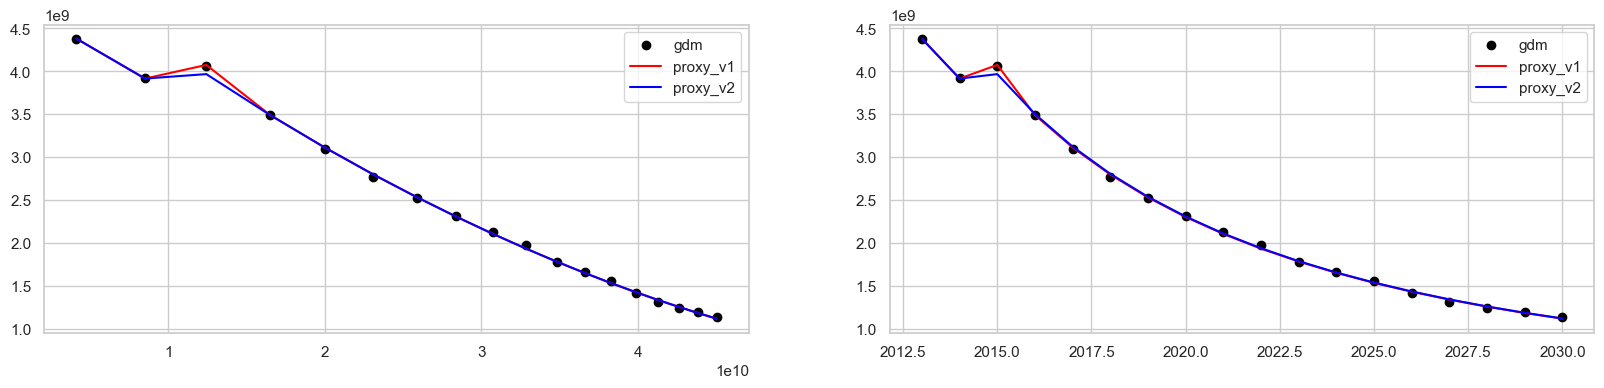

In [65]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize' : (20,10)}, style='whitegrid')
key='001-xxxx-xxxx-2015'

fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
ax[0].scatter(df[key].total, df[key].yearly, color='black', label='gdm')
ax[0].plot(df_res.x, df_res.y, label='proxy_v1', color='red')
ax[0].plot(df_res.x1, df_res.y1, label='proxy_v2', color='blue')
ax[0].legend()
ax[1].scatter(df[key].index.year.to_list(), df[key].yearly, color='black', label='gdm')
ax[1].plot(df_res.year, df_res.y, label='proxy_v1', color='red')
ax[1].plot(df_res.year, df_res.y1, label='proxy_v2', color='blue')
ax[1].legend()

print(mean_absolute_percentage_error(df[key].yearly, df_res.y))
print(mean_absolute_percentage_error(df[key].yearly, df_res.y1))

plt.show()